Primero importamos las librerías necesarias.

In [1]:
# Si importar Field da problemas entonces hacer un downgrade de torchtext a la versión 0.6:
# !pip install torchtext==0.6.0

import gc
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from nltk.translate.bleu_score import sentence_bleu
from torchtext.data import Field, TabularDataset, BucketIterator
import spacy # librería para NLP que funciona como tokenizador


device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando:", device)

Usando: cuda


Cargamos el Dataset con las frases en inglés y español. El dataset se obtuvo de https://www.kaggle.com/datasets/lonnieqin/englishspanish-translation-dataset.
Separamos el 90% para entrenamiento y el 10% restante para probar el modelo. No separamos un conjunto de validación ya que no vamos a afinar los hiperparámetros.

In [2]:
# Correr esta celda solo la primera vez

url = 'https://raw.githubusercontent.com/Nico7102/eng-esp-transformer-pytorch/main/data.csv'
data = pd.read_csv(url)
n = int(0.9*len(data))
train_data = data[:n]
test_data = data[n:]

In [3]:
try:
    os.mkdir('dataKaggle')
    print('carpeta data creada')
except OSError as error:
    print('carpeta data ya existe')
train_data.to_csv("dataKaggle/train.csv", index=False)
test_data.to_csv("dataKaggle/test.csv", index=False)
print('guardado en data')

carpeta data creada
guardado en data


Cargamos el tokenizador y construimos los vocabularios para los textos en inglés y español. (demora aproximadamente 5 minutos por la longitud del dataset)

In [4]:
spacy_en = spacy.load("en_core_web_sm")
spacy_es = spacy.load("es_core_news_sm")

def tokenize_en(text):
    return [token.text_with_ws for token in spacy_en.tokenizer(text)]

def tokenize_es(text):
    return [token.text_with_ws for token in spacy_es.tokenizer(text)]

english = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>")
spanish = Field(tokenize=tokenize_es, init_token="<sos>", eos_token="<eos>")

fields = {'english': ('src', english), 'spanish':('tgt', spanish)}

print("Construyendo splits")
train_data, test_data = TabularDataset.splits(
    path='dataKaggle',
    train='train.csv',
    test='test.csv',
    format='csv',
    fields=fields
)

print("Construyendo vocabularios")
english.build_vocab(train_data, max_size=16000, min_freq=1)
spanish.build_vocab(train_data, max_size=16000, min_freq=1)

Construyendo splits
Construyendo vocabularios


Se implementa el Transformer del paper "Attention Is All You Need", incluyendo el encoding posicional mencionado en el mismo.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x): # x.shape = (len<=max_len, batch_size, d_model)
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(
        self,
        src_tokenizer,
        d_model,
        src_vocab_size,
        tgt_vocab_size,
        src_pad_idx,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout,
        max_len,
        device
    ):
        super(Transformer, self).__init__()
        self.device = device

        self.tokenize = src_tokenizer

        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            dropout,
        )
        
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask.to(self.device)

    def forward(self, src, tgt):
        embed_src = self.dropout((self.pos_encoding(self.src_embedding(src))))
        embed_tgt = self.dropout((self.pos_encoding(self.tgt_embedding(tgt))))

        src_padding_mask = self.make_src_mask(src)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(self.device)

        out = self.transformer(
            embed_src,
            embed_tgt,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask,
        )
        del src_padding_mask
        del tgt_mask
        torch.cuda.empty_cache()
        out = self.fc_out(out)
        return out
    
    def translate(self, sentence, max_len_tr=100, return_tokens = False, use_best = False):
        if type(sentence) == str:
            tokens = self.tokenize(sentence)
        else:
            tokens = [token for token in sentence]
        
        tokens.insert(0, english.init_token)
        tokens.append(english.eos_token)

        text_to_indices = [english.vocab.stoi[token] for token in tokens]

        src_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(self.device)

        outputs = [english.vocab.stoi["<sos>"]]

        for i in range(max_len_tr):
            tgt_tensor = torch.LongTensor(outputs).unsqueeze(1).to(self.device)

            with torch.no_grad():
                logits = self(src_tensor, tgt_tensor)
                del tgt_tensor
                torch.cuda.empty_cache()

            if use_best:
                guess = logits.argmax(2)[-1, :].item()
            else:
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                guess = torch.multinomial(probs, num_samples=1)[-1, :].item()

            if guess == spanish.vocab.stoi["<eos>"]:
                break

            outputs.append(guess)
            
            # yield spanish.vocab.itos[guess] # iterador, regresa token por token estilo ChatGPT

        del src_tensor
        torch.cuda.empty_cache()
        out_tokens = [spanish.vocab.itos[idx] for idx in outputs][1:]
        if return_tokens:
            return out_tokens
        return ''.join(out_tokens)

In [6]:
# hiperparámetros

load_model = True
save_model = True

num_epochs = 30
learning_rate = 3e-4
batch_size = 512

d_model = 512 // 2
src_vocab_size = len(english.vocab)
tgt_vocab_size = len(spanish.vocab)
src_pad_idx = english.vocab.stoi["<pad>"]
nhead = 8 // 2
num_encoder_layers = 6 // 2
num_decoder_layers = 6 // 2
dim_feedforward = 2048 // (2**3)
dropout = 0.1
max_len = 100
n_eval = 100

In [7]:
def delete_tensors(*tensor_names, details = False):
    for name in tensor_names:
        del globals()[name]
        if details:
            print_memory_details(name)
    
    torch.cuda.empty_cache()
    

def total_memory():
    return(f"Memoria total en GPU: {torch.cuda.get_device_properties(0).total_memory / 1024 / 1024:.2f} MB")
def memory_reserved():
    return(f"Memoria reservada en GPU: {torch.cuda.memory_reserved() / 1024 / 1024:.2f} MB")
def memory_allocated():
    return(f"Memoria asignada en GPU: {torch.cuda.memory_allocated() / 1024 / 1024:.2f} MB")

def print_memory_details(s=None):
    if s is not None:
        print("-----------------",s,"-----------------",sep='')
    print(total_memory())
    print(memory_reserved())
    print(memory_allocated())

print_memory_details()

Memoria total en GPU: 6143.69 MB
Memoria reservada en GPU: 0.00 MB
Memoria asignada en GPU: 0.00 MB


In [8]:
torch.manual_seed(42)

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

model = Transformer(
    tokenize_en,
    d_model,
    src_vocab_size,
    tgt_vocab_size,
    src_pad_idx,
    nhead,
    num_encoder_layers,
    num_decoder_layers,
    dim_feedforward,
    dropout,
    max_len,
    device,
).to(device)    

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

c:\Users\nicoc\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\nicoc\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\nicoc\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [9]:
def bleu(data, test_len, model):
    bleu_score = []
    idxs = torch.randint(0,len(data),(test_len,)).tolist()
    for i in idxs:
        example = data[i]
        src = vars(example)["src"][:max_len-2]
        tgt = vars(example)["tgt"]

        with torch.no_grad():
            prediction = model.translate(src, return_tokens=True)
        bleu_score.append(sentence_bleu([tgt],prediction,weights=(1,)))

    return torch.tensor(bleu_score,dtype=torch.float64).mean().item()

In [10]:
loaded_epoch = 0

if load_model:
    try:
        checkpoint = torch.load("eng-esp-trainedKaggle.tar")
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        loaded_epoch = checkpoint["epoch"]
    except:
        print("No se pudo cargar el modelo")

def save_and_eval(epoch):
    print(f"[Epoch {epoch} / {num_epochs}]")

    if save_model:
        checkpoint = {
            "epoch":epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        print("Guardando modelo...")
        torch.save(checkpoint, "eng-esp-modelKaggle.tar")

    model.eval()
    score = bleu(test_data, n_eval, model)
    print("Accuracy en test:",score)
    model.train()
    return score

acc = []
for epoch in range(loaded_epoch, num_epochs):
    acc.append(save_and_eval(epoch))
    
    losses = []

    for batch_idx, batch in enumerate(train_iterator):
        torch.cuda.empty_cache()
        gc.collect()
        batch_src = batch.src[:max_len,:].to(device)
        batch_tgt = batch.tgt[:max_len,:].to(device)
        
        output = model(batch_src, batch_tgt[:-1, :])
        delete_tensors('batch_src')

        output = output.reshape(-1, output.shape[2])
        batch_tgt = batch_tgt[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, batch_tgt)
        delete_tensors('batch_tgt','output')
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        del batch

    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)

acc.append(save_and_eval(num_epochs))


No se pudo cargar el modelo
[Epoch 0 / 30]
Guardando modelo...


c:\Users\nicoc\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Accuracy en test: 0.0008000000000000003
0.0008000000000000003
[Epoch 1 / 30]
Guardando modelo...
Accuracy en test: 0.1693164776498999
0.1693164776498999
[Epoch 2 / 30]
Guardando modelo...
Accuracy en test: 0.2084894871552732
0.2084894871552732
[Epoch 3 / 30]
Guardando modelo...
Accuracy en test: 0.24313869679908812
0.24313869679908812
[Epoch 4 / 30]
Guardando modelo...
Accuracy en test: 0.2581599566872581
0.2581599566872581
[Epoch 5 / 30]
Guardando modelo...
Accuracy en test: 0.28052549056109305
0.28052549056109305
[Epoch 6 / 30]
Guardando modelo...
Accuracy en test: 0.29571865170470274
0.29571865170470274
[Epoch 7 / 30]
Guardando modelo...
Accuracy en test: 0.3141581135688576
0.3141581135688576
[Epoch 8 / 30]
Guardando modelo...
Accuracy en test: 0.3295039820862744
0.3295039820862744
[Epoch 9 / 30]
Guardando modelo...
Accuracy en test: 0.35385492679332187
0.35385492679332187
[Epoch 10 / 30]
Guardando modelo...
Accuracy en test: 0.3485001991976251
0.3485001991976251
[Epoch 11 / 30]
Gua

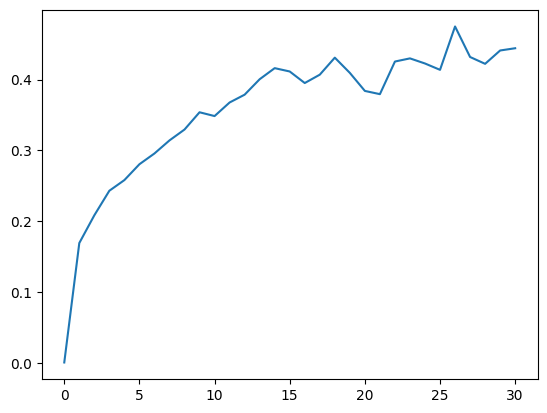

In [11]:
plt.plot(range(num_epochs+1),acc)

In [48]:
# sentence = "He is tall and strong."
sentence = "Hello, how are you?"

print(model.translate(sentence, use_best=True))

Hola, ¿cómo estás?
